# About

- `Title:` "Supervised Learning with Quantum-Inspired Tensor Networks"
- `Main Author:` Miles E. Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1605.05775)
- `Publish Date:` 18-05-2017
- `Reviewed Date:` 22-10-2021

## Citation

```latex
@article{stoudenmire2016supervised,
  title={Supervised learning with tensor networks},
  author={Stoudenmire, Edwin and Schwab, David J},
  journal={Advances in Neural Information Processing Systems},
  volume={29},
  year={2016}
}
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


# Imports and settings

In [3]:
import jax
import jax.numpy as jnp
from jax import jit

In [4]:
import itertools
import functools

In [5]:
jax.__version__

'0.3.10'

In [6]:
from typing import Any, List, Tuple, Callable, Optional

In [7]:
from plotting import plot, show_img_grid, set_figsize

In [8]:
import datasets  # MNIST downloader

## Type Aliaces

In [9]:
# type alias
Key = Any

Scalar = jnp.ndarray
Vector = jnp.ndarray
Matrix = jnp.ndarray
Tensor = jnp.ndarray

MPS = List[Tensor]

# PRN Key

In [10]:
key = jax.random.PRNGKey(321)

# Constants

In [11]:
bond_dim = 10       # the paper mentions 10, 20 and 120; WARNING: to avoid unnecessary truncation, set bond_dim>=num_classes
α = 1e-4            # learning rate
ε = 1e-1            # the allowed truncation error
num_sweeps = 4      # number of sweeps
train_size = 20000  # training set size

# Load data and visualise

In [12]:
train_images, train_labels, test_images, test_labels = datasets.mnist()

In [13]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (60000, 784) | Test data shape: (10000, 784)


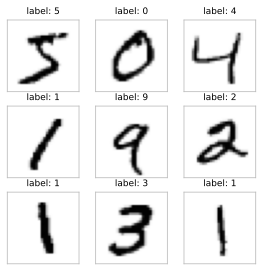

In [14]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images[i].reshape(28,28) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Downscaling images as in paper

In [15]:
def resize_img(
        img_vec: Vector,
        shape: Tuple[int,int]
    ) -> Vector:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img_mat = img_vec.reshape(orig_size, orig_size)
    img_mat = jax.image.resize(img_mat, shape, method='nearest')
    return img_mat.reshape(-1)

In [16]:
img_shape = (14,14)

resize_img_vmap = functools.partial(resize_img, shape=img_shape)

train_images_scaled = jax.vmap(resize_img_vmap)(train_images)
test_images_scaled = jax.vmap(resize_img_vmap)(test_images)

In [17]:
print(f'Train data shape: {train_images_scaled.shape} | Test data shape: {test_images_scaled.shape}')

Train data shape: (60000, 196) | Test data shape: (10000, 196)


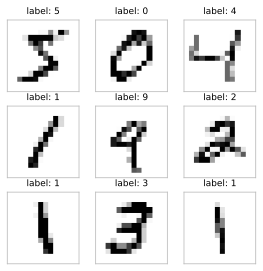

In [18]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images_scaled[i].reshape(img_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Feature Map

In [19]:
# as in the paper
def feature_map(x: Scalar) -> Vector:
    """Definine a feature map per pixel"""
    return jnp.array([
        jnp.cos(0.5 * jnp.pi * x),
        jnp.sin(0.5 * jnp.pi * x)
    ])

In [20]:
# applying the feature map in vectorized form
# exchanging axes for convenience (leading axes are the largest)
train_samples = jax.vmap(feature_map)(train_images_scaled).transpose(0,2,1)  
test_samples = jax.vmap(feature_map)(test_images_scaled).transpose(0,2,1)

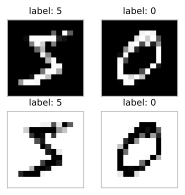

In [21]:
set_figsize((3.1,3.1))

# printing the images after the feature extraction
show_img_grid(
    [train_samples[i,:,j].reshape(img_shape) for j in range(2) for i in range(2)],
    [f'label: {jnp.argmax(train_labels[i])}' for i in range(2)]*2 
)

In [22]:
print(f'Train data shape: {train_samples.shape} | Test data shape: {test_samples.shape}')

Train data shape: (60000, 196, 2) | Test data shape: (10000, 196, 2)


# Sub-sample data

In [23]:
def subsample_data(key, data, amount=60000):
    """A helper to sub-sample data"""
    samples, labels = data        
    new_key, _ = jax.random.split(key)
    perm = jax.random.permutation(new_key, labels.shape[0])
    return samples[perm][:amount], labels[perm][:amount]

In [24]:
train_samples, train_labels = subsample_data(key, data=(train_samples, train_labels), amount=20000)

In [25]:
print(f'Train data shape: {train_samples.shape} | Test data shape: {test_samples.shape}')

Train data shape: (20000, 196, 2) | Test data shape: (10000, 196, 2)


In [149]:
train_labels.shape

(20000, 10)

In [112]:
train_samples.shape

(20000, 196, 2)

In [118]:
import quimb.tensor as qtn
import numpy as np

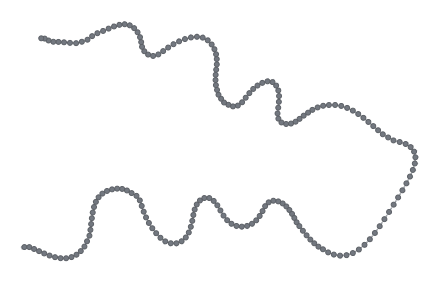

In [123]:
# Make initial MPS
L = train_samples.shape[1]
mps = []
initial_bond_dim = 2
phys_dim = 2
features = 10
mps.append( qtn.Tensor(inds = ['l', 'p0', '01'], data = (np.random.random((features, phys_dim, initial_bond_dim)))).unitize(left_inds = ['01']))
for i in np.array(range(L-2))+1:
    mps.append( qtn.Tensor(inds = [f'{i-1}{i}', f'p{i}', f'{i}{i+1}'], data = (np.random.random((initial_bond_dim, phys_dim, initial_bond_dim)))).unitize(left_inds = [f'p{i}', f'{i}{i+1}']))
mps.append( qtn.Tensor(inds = [f'{L-2}{L-1}', f'p{L-1}'], data = (np.random.random((initial_bond_dim, phys_dim)))).unitize(left_inds = [f'p{L-1}']))

qtn.TensorNetwork(mps).draw()

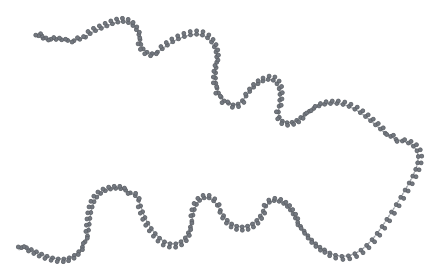

In [135]:
# Contract training samples with MPS
sample = np.random.randint(train_samples.shape[1])
sample_vecs = []
for i in range(train_samples.shape[1]):
    sample_vecs.append(qtn.Tensor(inds = [f'p{i}'], data = train_samples[sample,i,:]))
(qtn.TensorNetwork(mps) & qtn.TensorNetwork(sample_vecs)).draw()

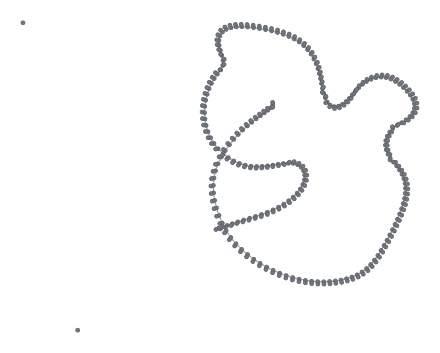

Tensor(shape=(2, 2, 2), inds=('12', 'p0', 'p1'), tags=oset([]), backend='numpy', dtype='float64')
Tensor(shape=(10,), inds=('l',), tags=oset([]), backend='numpy', dtype='float64')


In [148]:
# Find the gradient of a block 
opt_site = 0
residual_mps = mps[0:opt_site] + mps[opt_site+2:]
Φ = (qtn.TensorNetwork(residual_mps) & qtn.TensorNetwork(sample_vecs))
Φ.draw()
Φ = Φ.contract()
print(Φ)
ΦB = (Φ & qtn.TensorNetwork(mps[opt_site:opt_site+2])).contract()
print(ΦB)
ΔB = 

## MPS Utilities

In [26]:
def random_mps(
        key: Key,
        initializer: Callable,
        size: int,
        local_dim: int,
        bond_dim: int,
        labels_dim: Optional[int]=1,
    ) -> MPS:
    """
    Generate a random MPS where each core tensor
    is drawn according to the given initializer (see JAX docs).
    The result is a list of tensors indexed as follows:
    0 --o-- 2
        |    
        1    
    """
    left   = (1, local_dim, bond_dim)
    right  = (bond_dim, local_dim, labels_dim)
    middle = (bond_dim, local_dim, bond_dim)

    if size < 2:
        raise ValueError('Expectetd at least 2 sites for the MPS')
    elif size == 2:
        shapes = [left, right]
    else:       
        shapes = [left] + [middle]*(size-2) + [right]

    # generate multiple keys, so all tensors are different
    keys = jax.random.split(key, num=size)

    return jax.tree_map(initializer, list(keys), shapes)

In [27]:
def reverse_mps(
        params: MPS, 
        swapaxes: Optional[Tuple[int,int]]=(0,2)
    ) -> MPS:
    """
    A helper to reverse the MPS from left to right.
    The left and right legs are interchanged.
    The default change of indexing is as follows:
    0 --o-- 2     2 --o-- 0 
        |     =>      |
        1             1
    """
    swap_legs = lambda t: t.swapaxes(*swapaxes)
    return jax.tree_map(swap_legs, params[::-1])

In [28]:
@jit
def reverse_data(
        params: MPS, 
        samples: Tensor,
        wings: List[Matrix]
    ) -> Tuple[MPS, Tensor, List[Matrix]]:
    """A helper to reverse main data arounnd the features axis"""
    params_rev = reverse_mps(params)
    samples_rev = jnp.flip(samples, axis=1)
    wings_rev = wings[::-1]
    return params_rev, samples_rev, wings_rev

# Bond Truncation

In [70]:
def suggest_truncation(
        λ: Vector,
        ε: Optional[float]=1e-3  # truncation error tolerance
    ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    such that the truncation error is lower than ε.
    The spectrum is assumed to be in the descending order.
    """
    cum_sums = jnp.cumsum(λ / jnp.sum(jnp.power(λ, 2)))
    return jnp.searchsorted(cum_sums, 1-ε)

# Training-Related Functions

In [30]:
@jit
def project_sample(
        params: MPS, 
        sample: Matrix
    ) -> List[Matrix]:
    """
    A helper to project a single sample onto the MPS
    sites, e.g. contracting the local dimension only.
    --o--o--...--o--     
      |  |       |   => --o--o--...--o--
      o  o       o
    """
    # accounting for the possible labels dimension
    mult = lambda t, s: jnp.einsum('pjq...,j->pq...', t, s)
    return jax.tree_map(mult, params, list(sample))

@jit
def project_samples(
      params: MPS, 
      samples: Tensor
    ) -> List[Tensor]:
    """Projects multiple samples onto the MPS"""
    proj_func = functools.partial(project_sample, params)
    return jax.vmap(proj_func)(samples)

In [31]:
def loss(
        bond_tensor: Tensor,
        data: Tuple[List[Tensor], Matrix]
    ) -> Scalar:
    """Squared loss function"""
    # (Φ̃, δℓ) = data
    inputs, labels = data
    # Fig. 6c (fℓ(xₙ))
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *inputs, bond_tensor)
    err = preds - labels
    # implicit double sum in Eq.6
    return 0.5 * jnp.sum(jnp.power(err, 2))

In [32]:
def grad(
        bond_tensor: Tensor,
        data: Tuple[List[Tensor], Matrix]
    ) -> Scalar:
    """Manually calculate the squared loss gradient - Fig.6(c-d)"""
    # (Φ̃, δℓ) = data
    inputs, labels = data
    # Fig. 6c (fℓ(xₙ))
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *inputs, bond_tensor)
    # Fig. 6d
    err = preds - labels
    # positive gradient
    return jnp.einsum('mp,mij,mq,ml->pijql', *inputs, err)

In [33]:
@jit
def predict_label(
        params: MPS, 
        sample: Matrix
    ) -> Scalar:
    """A helper to predict the label for a single sample"""
    # project the test sample onto the mps
    projs = project_sample(params, sample)
    # reduce (full contraction)
    preds = functools.reduce(
        lambda x, y: jnp.einsum('pi...,iq...->pq...', x, y),
        projs
    )
    return jnp.argmax(preds)

@jit
def predict_labels(
        params: MPS, 
        samples: Tensor
    ) -> Scalar:
    """A helper to predict the label for a single sample"""
    pred_func = functools.partial(predict_label, params)
    return jax.vmap(pred_func)(samples)

In [34]:
def error_rate(
        params: List[Tensor], 
        data: Tuple[Tensor, Matrix]
    ) -> Scalar:
    """A helper to compute the error rate"""
    samples, labels = data
    # undo one-hot encoding of the labels
    labels = jnp.argmax(labels, axis=1)
    # predict labels for all samples
    labels_pred = predict_labels(params, samples)
    return 1 - jnp.sum(labels == labels_pred) / labels.size

# Initialize MPS

In [98]:
# getting the parameters
num_samples, num_features, dim_features = train_samples.shape
num_classes = train_labels.shape[1]

# initializer
initializer = jax.nn.initializers.uniform(scale=1)

# generating a random mps according to the initialiser
mps = random_mps(
    key, 
    initializer, 
    size=num_features, 
    local_dim=dim_features, 
    bond_dim=bond_dim,        # WARNING: to avoid unnecessary truncation, set bond_dim >= num_classes 
    labels_dim=num_classes
)

print(f'The MPS dimensions: size={num_features}, local_dim={dim_features}, bond_dim={bond_dim}')
print(f'Total number of paramters: {bond_dim**2 * dim_features * num_features}')

The MPS dimensions: size=196, local_dim=2, bond_dim=10
Total number of paramters: 39200


In [99]:
def left_normalize(
        params: MPS, 
        max_bond: int
    ) -> MPS:
    """Normalise the mps into the left-canonical form"""
    size = len(params)
    for pos in range(size):
        p, j, *_ = params[pos].shape
        M = params[pos].reshape(p*j,-1)
        # perform SVD
        U, λ, Vh = jnp.linalg.svd(M, full_matrices=False)
        # cutting off the bond dimension
        U  = U[:,:max_bond]   # truncate columns
        λ  = λ[:max_bond]     # truncate singular values
        Vh = Vh[:max_bond,:]  # truncate rows
        # assign the current tensor to U and reshape
        params[pos] = U.reshape(U.shape[0] // j, j, U.shape[1])
        # assigining the labels to the next tensor and reshape
        if pos < size - 1:
            M_next = params[pos+1].reshape(Vh.shape[1], -1)
            params[pos+1] = jnp.einsum('i,ij,jk->ik', λ, Vh, M_next).reshape(U.shape[1], j, -1)
    return params

In [100]:
# left normalizing the mps
mps = left_normalize(mps, max_bond=bond_dim)

In [101]:
# checking that the resulting mps is in the left-canonical form
mult = lambda e, t: jnp.einsum('pq,pjr,qjv->rv', e, t.conj(), t)
assert jnp.allclose(functools.reduce(mult, mps, jnp.eye(1)), jnp.eye(mps[-1].shape[-1]))

In [102]:
# reversing the mps gives the right-canonical form
mps_rev = reverse_mps(mps)
mult_rev = lambda e, t: jnp.einsum('rv,pjr,qjv->pq', e, t, t.conj())
# to apply the reduce function, we need to change the mps ordering (no leg swapping!)
assert jnp.allclose(functools.reduce(mult_rev, mps_rev[::-1], jnp.eye(1)), jnp.eye(mps_rev[0].shape[0]))

In [103]:
# extract the dimension corresponding to
# the labels, so we can move it during optimisation
mps[-1] = jnp.expand_dims(mps[-1], axis=2)

In [104]:
# printing shapes of the first and the last three tensors
print([t.shape for t in (*mps[:3],*mps[-3:])])

[(1, 2, 2), (2, 2, 4), (4, 2, 8), (10, 2, 10), (10, 2, 10), (10, 2, 1, 10)]


# Initialise the data store for the "left/right wings"

Initialise the data structure to store left/right wings. For the motivation, see the last paragraph on p4 in the paper. Below, I assume that the tensor with labels is the last in the MPS. After the initialisation, the order of the wings is reversed to allow the sweeps from the left on each run (with the labels being attached to the first tensor after reverting the order). This trick allows to move from left to right on every sweep simply by reverting the MPS, data features and the wings.

In [105]:
def max_normalize(tensor: Tensor) -> Tensor:
    """A helper to normalize a tensor"""
    return tensor / jnp.max(jnp.abs(tensor))

In [106]:
@jit
def init_wings(
        params: MPS,
        samples: Tensor,
    ) -> List[Vector]:
    """
    Initialise the local projections to keep linear
    scaling of the whole algorithm wrt sample size.
     ---
    | o-|-o--o--...--o--o        ▩--o--o--...--o--o      ▩--o--o
    | | | |  |       |  |   =>      |  |       |  |  =>     |  |
    | o | o  o       o  o           o  o       o  o         o  o
     ---
    """        
    # get the projections of samples onto the mps sites (excet the last two sites)
    projs = project_samples(params=params[:-2], samples=samples[:,:-2,:])

    # helper to contract neighbouring sites
    mult = lambda x, y: jnp.einsum('mpi,miq->mpq', x, y)
    # get the cumulative products computed from left to right
    cum_prods = itertools.accumulate(projs, mult)
    # removing axis=1, as the left-most leg is dummy and propagated
    # through the cumulative products
    wings = [p.squeeze(axis=1) for p in cum_prods]
    wings += [jnp.asarray(None)]*2  # the last two sites are dummy
    return wings

In [107]:
# an illustration of the operator.accumulate
# import operator
# list(itertools.accumulate([1,2,3,4,5,6,7,8,9], operator.mul))

In [108]:
# initialize the wings
wings = init_wings(mps, train_samples)
# normalize
wings = jax.tree_map(max_normalize, wings)

# Main Loop

In [109]:
# reverse data for convenience, so the iterations 
# are from left to right. Note, that the left 
# normalization of the MPS results in the right 
# normalization after the operation (as shown above)
mps, train_samples, wings = reverse_data(mps, train_samples, wings)

Below is a piece of code to check if the gradient is computed correctly. The two lines must be parallel to each other if this is the case (up to some numerical distortion at the end).

In [110]:
# def plot_taylor_apprx(β, data, num_iter=30):
#     dotp = lambda x,y : jnp.einsum('...,...->', x, y)
#     dβ = grad(β, data)
#     Δ = jax.random.uniform(key, shape=β.shape)
#     f = loss(β, data)

#     apprx, norms = [], []
#     for _ in range(num_iter):
#         Δf = loss(β + Δ, data)
#         apprx.append(jnp.linalg.norm(Δf - f - dotp(dβ, Δ)))
#         norms.append(dotp(Δ, Δ))
#         Δ /= 2

#     plot(jnp.arange(num_iter), [apprx, norms],
#          yscale='log', legend=['$\|f(x+Δx) - f(x) - ⟨∇f,Δx⟩\|^2$', '$\|Δx\|^2$'],
#          xlabel='Iterations', ylabel='$log{\|\cdot\|^2}$')

# pos = 0
# B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])
# inputs = train_samples[:,pos:pos+2,:]
# left_wing = jnp.ones(shape=(num_samples,1))
# Φ = [left_wing, inputs, wings[pos+2]]

# plot_taylor_apprx(B, data=(Φ, train_labels))

In [111]:
max_bond = 1

grads, losses = [], []
er_train, er_test = [], []

for sweep in range(num_sweeps):

    print('*'*100 + f'\nSweep: {sweep+1}\n' + '*'*100)

    for pos in range(len(mps)-1):

        # bond tensor - Fig.6a
        B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])
        
        # composing a tensor Φ - Fig.6b
        if pos == 0:
            left_wing = jnp.ones(shape=(num_samples, 1))
            right_wing = wings[pos+2]
        elif pos == len(mps)-2:
            left_wing = wings[pos-1]
            right_wing = jnp.ones(shape=(num_samples, 1))
        else:
            left_wing = wings[pos-1]
            right_wing = wings[pos+2]

        # not yet combining to a single tensor - saving space
        Φ = [left_wing, train_samples[:,pos:pos+2,:], right_wing]

        # compute the gradient update - Fig.6(c-d)
        ΔB = grad(B, data=(Φ, train_labels))
        
        # update the bond tensor - Fig.7a
        # note, that the paper  is using the 
        # negative gradient instead, so the 
        # plus sign there
        B_new = B - α * ΔB

        # SVD
        p,i,j,q,l = B_new.shape
        U, λ, Vh = jnp.linalg.svd(B_new.reshape(p*i, -1), full_matrices=False)

        # # cutting off the bond dimension
        # if λ.size > max_bond:
        #     # max_bond = suggest_truncation(λ, ε)  # adaptive bond dimension
        #     U  = U[:,:max_bond]
        #     λ  = λ[:max_bond]
        #     Vh = Vh[:max_bond,:]

        #normalize
        λ /= jnp.sum(jnp.power(λ, 2))
        
        # updating mps tesnors - Fig.7b
        mps[pos]   = U.reshape(U.shape[0] // i, i, U.shape[1])  # current position
        mps[pos+1] = jnp.einsum('i,ij->ij', λ, Vh).reshape(U.shape[1], j, q, l)  # next position

        # project input samples onto the new tensor at current position and update the left wing - Fig.7c
        projs_at_pos = project_samples(params=mps[pos:pos+1], samples=train_samples[:,pos:pos+1,:])
        if pos == 0:
            left_wing = jnp.asarray(projs_at_pos).squeeze(axis=(0,2))  # 0 index is due to len(MPS) = 1
                                                                       # 2 index is due to the left most
                                                                       # dim of the first tensor
        else:
            left_wing = jnp.einsum(
                'mp,mpq->mq', 
                left_wing, 
                jnp.asarray(projs_at_pos).squeeze(axis=0)  # 0 index is due to len(MPS) = 1
            )

        # normalize and update the wing
        wings[pos] = max_normalize(left_wing)

        # storing the loss and gradient norms
        grads.append(jnp.linalg.norm(ΔB))
        losses.append(loss(B_new, data=(Φ, train_labels)))

        # Train/test error rates
        # er_train.append(error_rate(mps, data=(train_samples, train_labels)))
        # er_test.append(error_rate(mps, data=(test_samples, test_labels)))

        print(
            '\t|\t'.join(
                [f'Updated site: {pos:<5}',
                 f'Loss: {losses[-1]:<10e}',
                 f'Gradient norm: {grads[-1]:<10e}',
                 f'Bond Dim: {λ.size:<5}',
                #  f'Train/Test ER: {er_train[-1]}/{er_test}'
                ]) 
        )

    # prepare everything for the next sweep
    mps, train_samples, wings = reverse_data(mps, train_samples, wings)

****************************************************************************************************
Sweep: 1
****************************************************************************************************
Updated site: 0    	|	Loss: 1.000017e+04	|	Gradient norm: 1.280238e+01	|	Bond Dim: 2    
Updated site: 1    	|	Loss: 1.000010e+04	|	Gradient norm: 1.905862e+01	|	Bond Dim: 4    
Updated site: 2    	|	Loss: 1.000410e+04	|	Gradient norm: 2.851056e+01	|	Bond Dim: 8    
Updated site: 3    	|	Loss: 9.999823e+03	|	Gradient norm: 2.798889e+01	|	Bond Dim: 16   
Updated site: 4    	|	Loss: 9.999618e+03	|	Gradient norm: 2.474575e+01	|	Bond Dim: 32   
Updated site: 5    	|	Loss: 9.999957e+03	|	Gradient norm: 1.529262e+01	|	Bond Dim: 64   
Updated site: 6    	|	Loss: 9.999799e+03	|	Gradient norm: 1.493183e+01	|	Bond Dim: 128  
Updated site: 7    	|	Loss: 9.999957e+03	|	Gradient norm: 1.594628e+01	|	Bond Dim: 200  
Updated site: 8    	|	Loss: 9.999746e+03	|	Gradient norm: 1.641955e+01	|	Bond

KeyboardInterrupt: 

In [ ]:
plot(
    jnp.arange(len(grads)), 
    [grads], 
    xlabel='Steps',
    ylabel='$\|\Delta{B}\|_2$',
    title='Gradient norm dynamics'
    )

In [ ]:
plot(
    jnp.arange(len(losses)), [losses], 
    yscale='log',
    xlabel='Steps',
    ylabel='Loss',
    title='Loss function dynamics')

# Calculating The Error Rate

In [51]:
er_train = error_rate(mps, data=(train_samples, train_labels))
er_test = error_rate(mps, data=(test_samples, test_labels))

In [52]:
print(f'Error rate train: {er_train:<5.2f}\t|\tError rate test: {er_test:<5.2f}')

Error rate train: 0.87 	|	Error rate test: 0.88 


In [ ]:
\lambda\_H\^{h}